### Implementing DEEP WALK

In [62]:
import numpy as np
from random import randint, choice
from gensim.models import Word2Vec
import networkx as nx
import plotly.express as px
from tqdm import tqdm
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pykeen.pipeline import pipeline

In [42]:

def random_walk(G, node, walk_length):

    walk = []
    for i in range(walk_length):
        node = choice(list(G.neighbors(node)))
        walk.append(node)

    walk = [str(node) for node in walk]
    return walk

def random_walk_gen(G,node,walk_length,p):
    walk = []
    for i in range(walk_length):
        node = choice(list(G.neighbors(node)))
        node_p=choice(list(G.nodes))
        node=choice([node,node_p],weights=[1-p,p])
        walk.append(node)

    walk = [str(node) for node in walk]
    return walk

In [43]:
def generate_walks(G, num_walks, walk_length):
    walks = []

    for node in tqdm(np.random.permutation(G.nodes())):
        for i in range(num_walks):
            walks.append(random_walk(G,node,walk_length))

    return walks

In [44]:
def deepwalk(G,window_size,embed_size, num_walks, walk_length):
    print("Generating walks")
    walks = generate_walks(G, num_walks, walk_length)
    
    print("Training word2vec")
    model = Word2Vec(vector_size=embed_size, window=window_size, min_count=0, sg=1, workers=20, hs=1)
    model.build_vocab(walks)
    model.train(walks, total_examples=model.corpus_count, epochs=5)

    return model

### Testing on Blogcatalog dataset

In [45]:
edges = np.loadtxt('BlogCatalog-dataset/data/edges.csv', delimiter=',', dtype=int)
nodes = pd.read_csv('BlogCatalog-dataset/data/nodes.csv', index_col=0,header=None)

In [46]:
# Create a graph from the edges file
graph = nx.Graph()
graph.add_edges_from(edges[:200])
graph.add_nodes_from(nodes.index[:200])

In [47]:
print('Number of edges :',len(edges),'Nodes :',len(nodes))

Number of edges : 333983 Nodes : 10312


In [55]:
degree_list = sorted([graph.degree(i) for i in graph], reverse=True)

In [58]:
print("Maximum degree: {}".format(degree_list[0]))
print("Minimum degree: {}".format(degree_list[-1]))
print("Mean of degree distribution: {}".format(np.mean(degree_list)))
print("Std variation of degree distribution: {}".format(np.std(degree_list)))

Maximum degree: 3992
Minimum degree: 1
Mean of degree distribution: 64.7756012412723
Std variation of degree distribution: 177.6973696826509


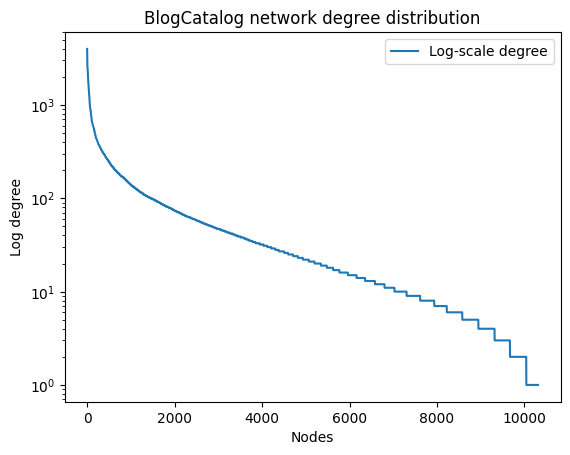

In [59]:
plt.subplot(111)
plt.semilogy(degree_list)
plt.title("BlogCatalog network degree distribution")
plt.ylabel("Log degree")
plt.xlabel("Nodes")
plt.legend(["Log-scale degree"])

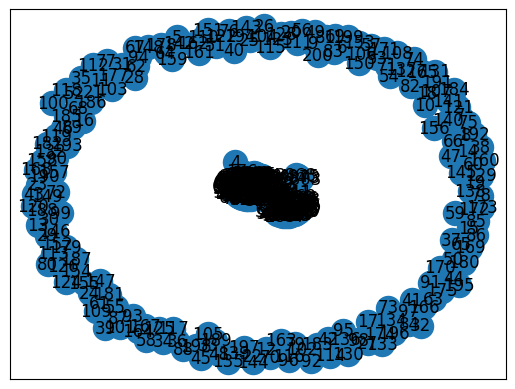

In [48]:
# Driver code
nx.draw_networkx(graph)
plt.show()

In [49]:
# Create a graph from the edges file
graph = nx.Graph()
graph.add_edges_from(edges)
graph.add_nodes_from(nodes.index)

In [50]:
nodes_df = pd.read_csv('BlogCatalog-dataset/data/group-edges.csv', header=None, names=['id', 'labels'])

In [51]:
nodes_df

,id,labels
0,28,1
1,32,1
2,36,1
3,37,1
4,84,1
...,...,...
14471,1344,39
14472,1465,39
14473,1550,39
14474,4709,39


In [52]:
fig = px.histogram(nodes_df, x="labels")
fig.show()

In [106]:
label_mat=np.zeros((len(nodes),39))
indexes=nodes_df.values-1
for a,b in indexes:
    label_mat[a,b]=1

In [103]:
embed_size=128
num_walks = 80
walk_length = 40
window_size=10
# si on veut refaire le training
##################
#model = deepwalk(graph,window_size,embed_size, num_walks, walk_length)

In [18]:
# Save the model for later
#model.save('my_model')

In [104]:
model = Word2Vec.load('my_model')

In [107]:
n=len(nodes)
embeddings = np.zeros((n, embed_size))
labels=np.zeros((n,39))
for i, node in enumerate(graph.nodes()):
    embeddings[i,:] = model.wv[str(node)]
    labels[i,:]=label_mat[node-1]


idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

X_train = embeddings[idx_train,:]
X_test = embeddings[idx_test,:]

y_train = labels[idx_train]
y_test = labels[idx_test]

In [116]:
from collections import defaultdict
from gensim.models import Word2Vec, KeyedVectors
from six import iteritems
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from scipy.io import loadmat
from sklearn.utils import shuffle as skshuffle
from sklearn.preprocessing import MultiLabelBinarizer

class TopKRanker(OneVsRestClassifier):
    def predict(self, X, top_k_list):
        assert X.shape[0] == len(top_k_list)
        probs = np.asarray(super(TopKRanker, self).predict_proba(X))
        all_labels = []
        for i, k in enumerate(top_k_list):
            probs_ = probs[i, :]
            labels = self.classes_[probs_.argsort()[-k:]].tolist()
            all_labels.append(labels)
        return all_labels

def sparse2graph(x):
    G = defaultdict(lambda: set())
    cx = x.tocoo()
    for i,j,v in zip(cx.row, cx.col, cx.data):
        G[i].add(j)
    return {str(k): [str(x) for x in v] for k,v in iteritems(G)}



  
  # 1. Load Embeddings
model = model

labels_matrix = label_mat
labels_count = labels_matrix.shape[1]
  
# Map nodes to their features (note:  assumes nodes are labeled as integers 1:N)
features_matrix = embeddings

# 3. to score each train/test group
all_results = defaultdict(list)

clf = TopKRanker(LogisticRegression())
clf.fit(X_train, y_train)
top_k_list = [int(np.sum(l)) for l in y_test]
preds=clf.predict(X_test,top_k_list)

In [109]:
mlb = MultiLabelBinarizer(classes=range(labels_count))

In [17]:
results = {}
averages = ["micro", "macro"]
for average in averages:
    results[average] = f1_score(y_test, mlb.fit_transform(preds), average=average)

print(results)

{'micro': 0.4276025771447948, 'macro': 0.2804540027422445}


In [22]:
results = {}
averages = ["micro", "macro"]
for average in averages:
    results[average] = precision_score(y_test, mlb.fit_transform(preds), average=average)

print(results)

{'micro': 0.4276025771447948, 'macro': 0.36681257982251964}


/Users/aminelarhchim/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [117]:
results = {}
averages = ["micro", "macro"]
for average in averages:
    results[average] = recall_score(y_test, mlb.fit_transform(preds), average=average)

print(results)

{'micro': 0.4276025771447948, 'macro': 0.26641925849815923}


In [114]:
embeddings

array([[ 0.04239498, -0.13170709, -0.06011489, ...,  0.06454545,
         0.08654186, -0.3818405 ],
       [ 0.15490001, -0.02605605, -0.05298505, ..., -0.01687646,
        -0.1006452 ,  0.11429615],
       [ 0.11922279,  0.00618909,  0.05891945, ..., -0.07707897,
        -0.08953776,  0.05917153],
       ...,
       [ 0.33991382, -0.21023755,  0.15971643, ...,  0.48196203,
        -0.40993705, -0.18641667],
       [ 0.19246489,  0.02232569,  0.3727366 , ...,  0.41515493,
         0.02425628, -0.41993818],
       [ 0.02655278, -0.39179331,  0.14924735, ...,  0.39243072,
         0.0714936 , -0.1828707 ]])